In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline    
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mazlu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mazlu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mazlu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mazlu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')  # Load your dataset here
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [5]:
df.duplicated().sum()

np.int64(403)

In [6]:
df.drop_duplicates(inplace=True,keep='first')

Text(0, 0.5, 'Number of Data points')

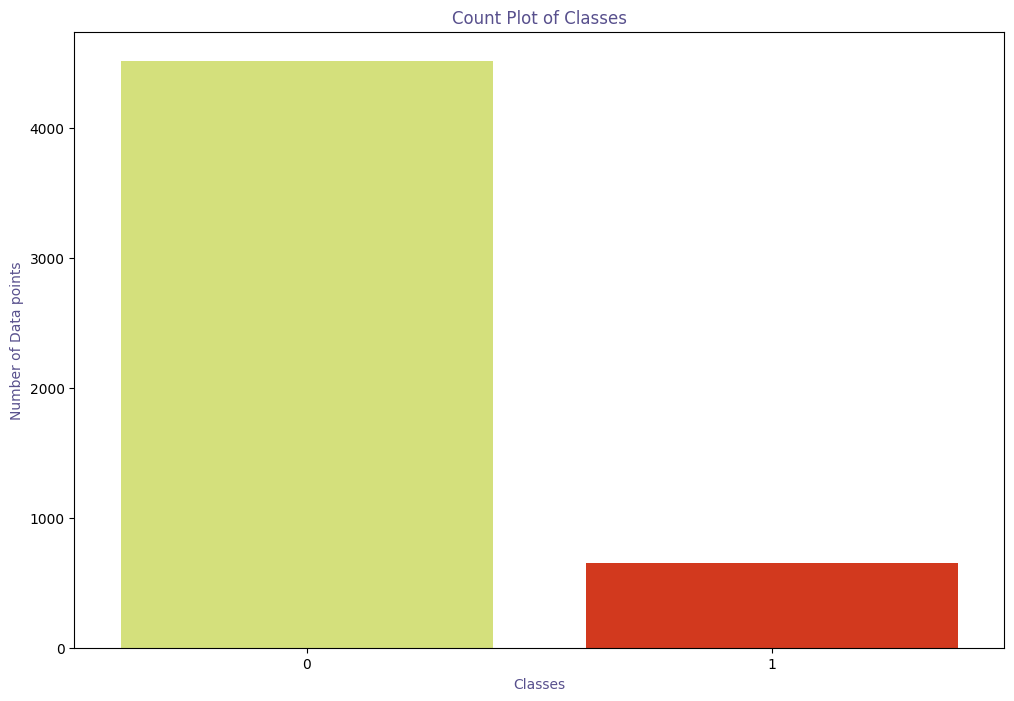

In [7]:
cols= ["#E1F16B", "#F02400"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= df["label"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [9]:
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df['clean_text'] = df['text'].apply(Clean)

In [34]:
print("The First 5 Texts after cleaning:",*df["clean_text"][:5], sep = "\n")

The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [11]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df[['num_characters', 'num_words', 'num_sentence']].describe()


,num_characters,num_words,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [12]:
#for ham
df[df['label'] == 0][['num_characters', 'num_words', 'num_sentence']].describe()


,num_characters,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [13]:
#for spam
df[df['label'] == 1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


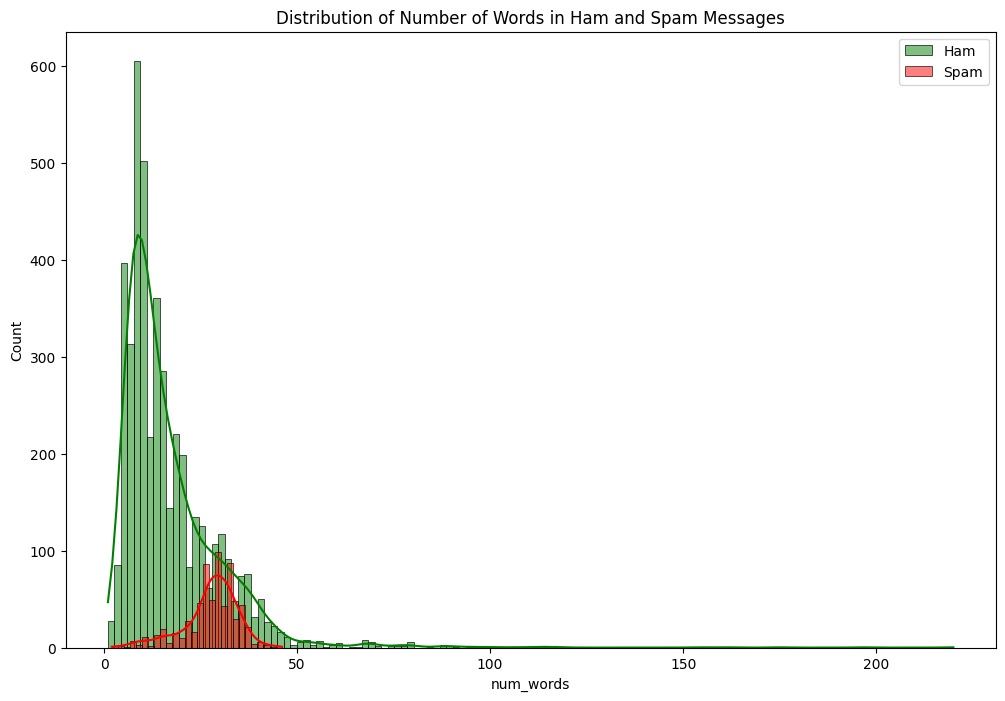

In [14]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['label'] == 0]['num_words'], color='green', label='Ham', kde=True)
sns.histplot(df[df['label'] == 1]['num_words'], color='red', label='Spam', kde=True)
plt.title('Distribution of Number of Words in Ham and Spam Messages')
plt.legend()
plt.show()

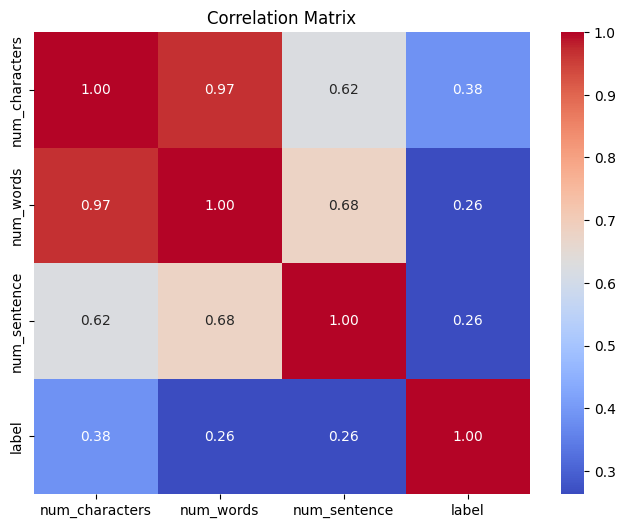

In [15]:
#corr matrix
corr = df[['num_characters', 'num_words', 'num_sentence', 'label']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [16]:
df.head()

,label,text,clean_text,num_characters,num_words,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,111,24,2
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,155,37,2
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,61,15,1


In [17]:
ps = PorterStemmer()
def transform_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and len(i) > 2:
            y.append(ps.stem(i))
    return " ".join(y)

transform_text("This is an example for text transformation!!")

'exampl text transform'

In [18]:
df['transformed_text'] = df['clean_text'].apply(transform_text)
df.head()

,label,text,clean_text,num_characters,num_words,num_sentence,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,111,24,2,jurong point crazi avail bugi great world buff...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,29,8,2,lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,155,37,2,free entri wkli comp win cup final tkt may tex...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,49,13,1,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,61,15,1,nah think goe usf live around though


(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

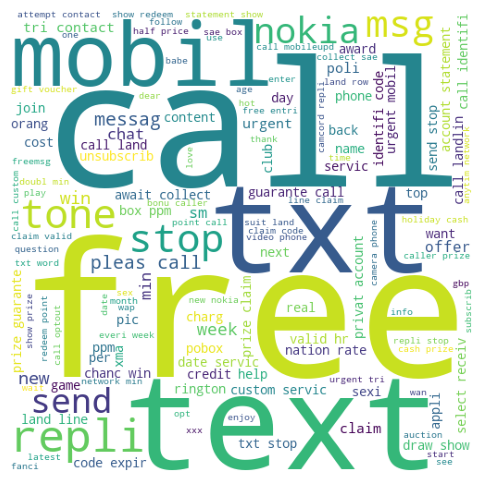

In [36]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['label'] == 1]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.axis("off")

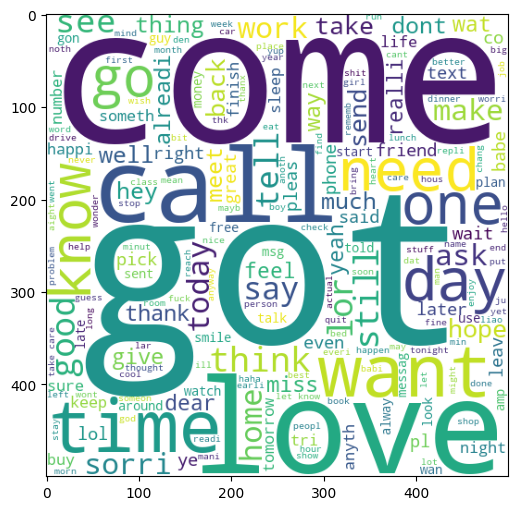

In [20]:
ham_wc = wc.generate(df[df['label'] == 0]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(ham_wc)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(   )
tfid = TfidfVectorizer()
X = tfid.fit_transform(df['transformed_text']).toarray()
y = df['label'].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [24]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging Classifier": BaggingClassifier(),
    "Extra Trees Classifier": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier()
}

In [25]:
def calculate_comprehensive_metrics(y_true, y_pred, y_pred_proba=None):
    """Kapsamlı model değerlendirme metrikleri"""
   
    # Temel metrikler
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
   
    # ROC-AUC (probability tahminleri gerekli)
    roc_auc = None
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
   
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
   
    # Classification Report
    cl_report = classification_report(y_true, y_pred)
   
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'classification_report': cl_report
    }


In [26]:
results_df = []


for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
   
    # Model eğitimi
    model.fit(X_train, y_train)
   
    # Tahminler
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
   
    # Probability tahminleri (ROC-AUC için)
    try:
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    except:
        # SVM gibi bazı modeller için probability=True gerekli
        y_train_proba = None
        y_test_proba = None
   
    # Train metrikleri
    train_metrics = calculate_comprehensive_metrics(y_train, y_train_pred, y_train_proba)
   
    # Test metrikleri
    test_metrics = calculate_comprehensive_metrics(y_test, y_test_pred, y_test_proba)
   
    # Sonuçları yazdır
    print("\nTRAIN SET RESULTS:")
    print(f"Accuracy:  {train_metrics['accuracy']:.4f}")
    print(f"Precision: {train_metrics['precision']:.4f}")
    print(f"Recall:    {train_metrics['recall']:.4f}")
    print(f"F1-Score:  {train_metrics['f1_score']:.4f}")
    if train_metrics['roc_auc']:
        print(f"ROC-AUC:   {train_metrics['roc_auc']:.4f}")
   
    print("\nTEST SET RESULTS:")
    print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall:    {test_metrics['recall']:.4f}")
    print(f"F1-Score:  {test_metrics['f1_score']:.4f}")
    if test_metrics['roc_auc']:
        print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f}")
   
    # DataFrame için sonuçları kaydet
    results_df.append({
        'Model': name,
        'Train_Accuracy': train_metrics['accuracy'],
        'Test_Accuracy': test_metrics['accuracy'],
        'Train_Precision': train_metrics['precision'],
        'Test_Precision': test_metrics['precision'],
        'Train_Recall': train_metrics['recall'],
        'Test_Recall': test_metrics['recall'],
        'Train_F1': train_metrics['f1_score'],
        'Test_F1': test_metrics['f1_score'],
        'Train_ROC_AUC': train_metrics['roc_auc'],
        'Test_ROC_AUC': test_metrics['roc_auc']
    })


# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results_df)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.round(4))



Model: Logistic Regression

TRAIN SET RESULTS:
Accuracy:  0.9644
Precision: 0.9796
Recall:    0.7195
F1-Score:  0.8296
ROC-AUC:   0.9964

TEST SET RESULTS:
Accuracy:  0.9528
Precision: 0.9562
Recall:    0.7043
F1-Score:  0.8111
ROC-AUC:   0.9863

Model: Support Vector Machine

TRAIN SET RESULTS:
Accuracy:  0.9966
Precision: 1.0000
Recall:    0.9722
F1-Score:  0.9859

TEST SET RESULTS:
Accuracy:  0.9729
Precision: 1.0000
Recall:    0.8118
F1-Score:  0.8961

Model: Naive Bayes

TRAIN SET RESULTS:
Accuracy:  0.9667
Precision: 1.0000
Recall:    0.7238
F1-Score:  0.8398
ROC-AUC:   0.9923

TEST SET RESULTS:
Accuracy:  0.9567
Precision: 1.0000
Recall:    0.6989
F1-Score:  0.8228
ROC-AUC:   0.9798

Model: Decision Tree

TRAIN SET RESULTS:
Accuracy:  0.9997
Precision: 1.0000
Recall:    0.9979
F1-Score:  0.9989
ROC-AUC:   1.0000

TEST SET RESULTS:
Accuracy:  0.9575
Precision: 0.8429
Recall:    0.8656
F1-Score:  0.8541
ROC-AUC:   0.9131

Model: K-Nearest Neighbors

TRAIN SET RESULTS:
Accuracy:  

In [27]:
random_forest = RandomForestClassifier()
random_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
random_forest_randomized = RandomizedSearchCV(estimator=random_forest, param_distributions=random_params, n_iter=100, cv=3, verbose=2, random_state=42)

In [28]:
random_forest_randomized.fit(X_train, y_train)
random_forest_randomized.best_params_
y_pred = random_forest_randomized.predict(X_test)
accuracy_score(y_test, y_pred)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   5.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   5.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   5.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  11.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  11.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  12.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  13.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  12.8s
[CV] END max_dep

0.97138437741686

In [29]:
xgb = XGBClassifier()
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_randomized = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=100, cv=3, verbose=2, random_state=42)
xgb_randomized.fit(X_train, y_train)
xgb_randomized.best_params_
y_pred_xgb = xgb_randomized.predict(X_test)
accuracy_score(y_test, y_pred_xgb)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.6; total time=   3.6s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.6; total time=   2.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   3.2s
[CV] END co

0.9791183294663574

In [30]:
random_forest_randomized.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': None}

In [31]:
xgb_randomized.best_params_


{'subsample': 0.6,
 'n_estimators': 300,
 'max_depth': 7,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6}

In [32]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier(subsample=0.6, n_estimators=300, max_depth=7, learning_rate=0.1, colsample_bytree=0.6))
])
pipeline.fit(df['transformed_text'], df['label'])
import joblib
joblib.dump(pipeline, 'spam_classifier_model.pkl')

['spam_classifier_model.pkl']